/var/folders/3h/75v0nlln0l5bj3dkh_dmtrrc0000gq/T/ipykernel_24576/812476331.py:115: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


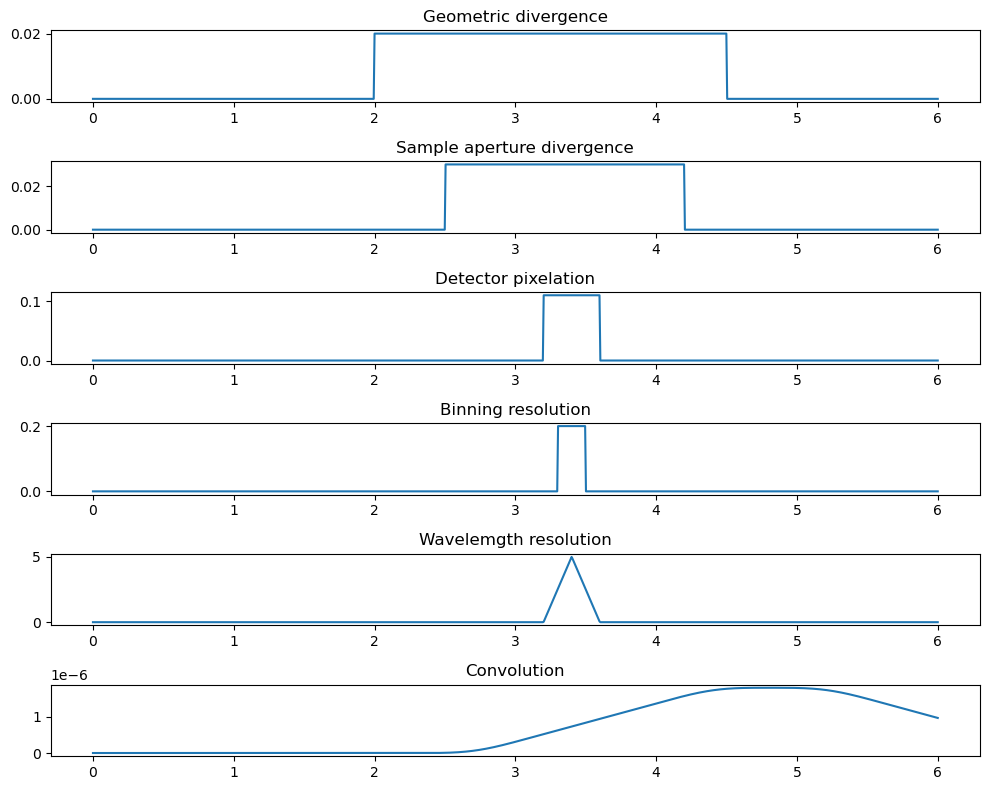

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define two probability distribution functions

def pdf1(x):
    return np.exp(-x**2)

def pdf2(x):
    return np.exp(-(x - 2)**2)

def top_hat(x, a, b, c):
    """
    x: Input array of values
    a: Start of the interval where the function is non-zero
    b: End of the interval where the function is non-zero
    c: Height of the constant value within the interval
    """
    return np.where((x >= a) & (x <= b), c, 0)
    
def triangular_distribution(x, a, b, c):
    """
    x: Input array of values
    a: Minimum value
    b: Mode (most frequent value)
    c: Maximum value
    """
    return np.where((x >= a) & (x <= c),
                    np.where(x < b,
                             2*(x - a) / ((c - a) * (b - a)),
                             2*(c - x) / ((c - a) * (c - b))),
                    0)

# Define the range of values for the PDFs
x_values = np.linspace(0, 6, 1000)

a_tri = -2
b_tri = 2
c_tri = 6

# Compute the convolution using numpy's convolve function

# Plot the original PDFs and the convolved PDF
plt.figure(figsize=(10, 8))


#Geometric divergence
a_top = 2  
b_top = 4.5 
c_top = 0.02

geometric_divergence = top_hat(x_values, a_top, b_top, c_top)

#Sample aperture smearing
a_top = 2.5  
b_top = 4.2 
c_top = 0.03

sample_aperture_smearing = top_hat(x_values, a_top, b_top, c_top)

#Detector pixelation
a_top = 3.2 
b_top = 3.6 
c_top = 0.11

detector_pixelation = top_hat(x_values, a_top, b_top, c_top)

#Binning resolution

a_top = 3.3 
b_top = 3.5 
c_top = 0.2

binning_resolution = top_hat(x_values, a_top, b_top, c_top)

#Wavelength resolution

a_top = 3.2 
b_top = 3.4 
c_top = 3.6

wavelength_resolution = triangular_distribution(x_values, a_top, b_top, c_top)

convolution = np.convolve(geometric_divergence, sample_aperture_smearing, mode='same') * (x_values[1] - x_values[0])
convolution = np.convolve(convolution, detector_pixelation, mode='same') * (x_values[1] - x_values[0])
convolution = np.convolve(convolution, binning_resolution, mode='same') * (x_values[1] - x_values[0])
convolution = np.convolve(convolution, wavelength_resolution, mode='same') * (x_values[1] - x_values[0])


plt.subplot(6, 1, 1)
plt.plot(x_values, geometric_divergence)
plt.title('Geometric divergence')

plt.subplot(6, 1, 2)
plt.plot(x_values, sample_aperture_smearing)
plt.title('Sample aperture divergence')


plt.subplot(6, 1, 3)
plt.plot(x_values, detector_pixelation)
plt.title('Detector pixelation')

plt.subplot(6, 1, 4)
plt.plot(x_values, binning_resolution)
plt.title('Binning resolution')

plt.subplot(6, 1, 5)
plt.plot(x_values, wavelength_resolution)
plt.title('Wavelemgth resolution')
plt.tight_layout()

plt.subplot(6, 1, 6)
plt.plot(x_values, convolution)
plt.title('Convolution')
plt.tight_layout()


#convolution = np.convolve(top_hat(x_values, a_top, b_top, c_top), triangular_distribution(x_values, a_tri, b_tri, c_tri), mode='same') * (x_values[1] - x_values[0])
plt.show()


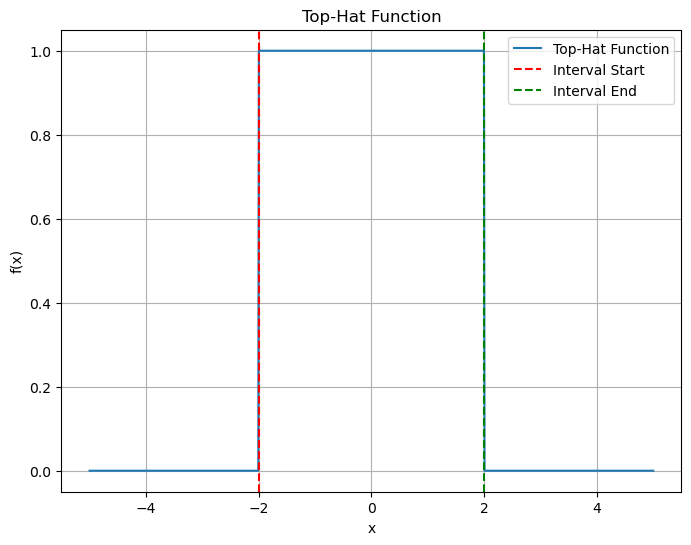

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the top-hat function
def top_hat(x, a, b, c):
    """
    x: Input array of values
    a: Start of the interval where the function is non-zero
    b: End of the interval where the function is non-zero
    c: Height of the constant value within the interval
    """
    return np.where((x >= a) & (x <= b), c, 0)

# Define the range of x values
x_values = np.linspace(-5, 5, 1000)

# Parameters for the top-hat function
a = -2  # Start of the interval
b = 2   # End of the interval
c = 1   # Height of the constant value

# Calculate the top-hat function values
top_hat_values = top_hat(x_values, a, b, c)

# Plot the top-hat function
plt.figure(figsize=(8, 6))
plt.plot(x_values, top_hat_values, label='Top-Hat Function')
plt.axvline(x=a, color='r', linestyle='--', label='Interval Start')
plt.axvline(x=b, color='g', linestyle='--', label='Interval End')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Top-Hat Function')
plt.legend()
plt.grid()
plt.show()


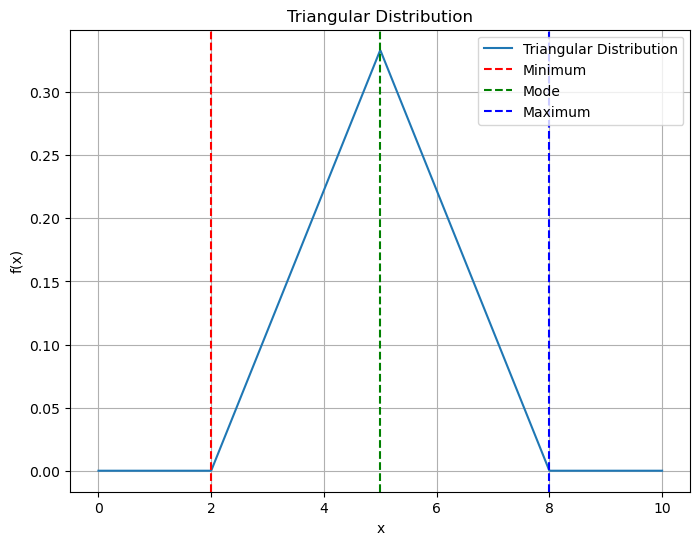

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the triangular distribution function
def triangular_distribution(x, a, b, c):
    """
    x: Input array of values
    a: Minimum value
    b: Mode (most frequent value)
    c: Maximum value
    """
    return np.where((x >= a) & (x <= c),
                    np.where(x < b,
                             2*(x - a) / ((c - a) * (b - a)),
                             2*(c - x) / ((c - a) * (c - b))),
                    0)

# Define the range of x values
x_values = np.linspace(0, 10, 1000)

# Parameters for the triangular distribution
a = 2   # Minimum value
b = 5   # Mode (most frequent value)
c = 8   # Maximum value

# Calculate the triangular distribution values
triangular_values = triangular_distribution(x_values, a, b, c)

# Plot the triangular distribution
plt.figure(figsize=(8, 6))
plt.plot(x_values, triangular_values, label='Triangular Distribution')
plt.axvline(x=a, color='r', linestyle='--', label='Minimum')
plt.axvline(x=b, color='g', linestyle='--', label='Mode')
plt.axvline(x=c, color='b', linestyle='--', label='Maximum')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Triangular Distribution')
plt.legend()
plt.grid()
plt.show()
